In [117]:
from pathlib import Path
from typing import List, Tuple, Dict

# Wav Features and Visualization
import librosa
import IPython.display as ipd
from IPython.core.display import display
# Basics
import numpy as np
import pandas as pd
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Machine Learning
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm_notebook
import tqdm
import xgboost

# View Data

In [96]:
def load_wav(path: str, sample_rate: int) -> np.ndarray:
    waveform, _ = librosa.load(path, sr=sample_rate)
    return waveform


def extract_features(
        file_path: str, 
        sample_rate: int=22050,
        hop_length: int=220,
        n_fft: int=2048,
        n_frames_per_example: int=1
    ) -> List[np.ndarray]:
    
    waveform = load_wav(file_path, sample_rate=sample_rate)
    
    spectrogram = librosa.feature.melspectrogram(
        waveform, n_fft=n_fft, hop_length=hop_length,
    )
    
    spectrogram = np.log(1e-20 + np.abs(spectrogram ** 2))
    
    n_examples = spectrogram.shape[1] // n_frames_per_example
    
    return [
        spectrogram[
            :,
            i*n_frames_per_example:(i+1) * n_frames_per_example
        ].reshape(1, -1)
        for i in range(n_examples)
    ]

/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_84086/3346447856.py:16: FutureWarning: Pass y=[-0.16705322 -0.16708374 -0.15670776 ...  0.1411438   0.17166138
  0.19277954] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(


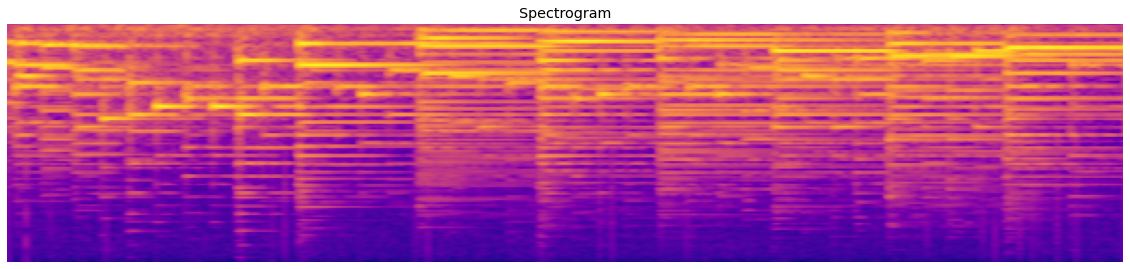

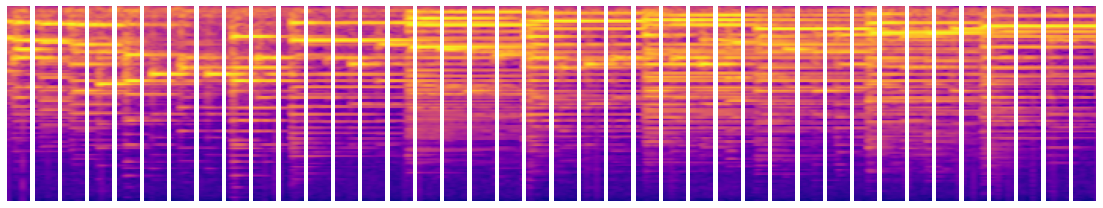

In [97]:
path = 'data/train/train/classical/1429195257218202828.wav'
# 1161154212832220511.wav
# 1429195257218202828.wav
n_frames_per_example = 15
axis = False
dis = ipd.Audio(filename=path)
display(dis)

features = extract_features(path, n_frames_per_example=n_frames_per_example)

features = [
    feature.reshape(-1, n_frames_per_example)
    for feature in features
]

plt.figure(figsize=(20,5))
plt.title('Spectrogram')
plt.imshow(np.hstack(features), cmap='plasma')
if axis:
    plt.xlabel('seconds')
    plt.ylabel('mel')
else:
    plt.axis('off')
plt.savefig('spectrogram.png', dpi=200)
plt.show()

plt.figure(figsize=(20,5))
for i, feature in enumerate(features):
    plt.subplot(1, len(features) + 1, i + 1)
    plt.imshow(feature, cmap='plasma')
    plt.axis('off')
plt.show()

# Prepare Train Dataset

In [98]:
def load_wav(path: Path, sr: int=8000) -> Tuple[np.ndarray, int]:
    return librosa.load(path, sr=sr)

In [99]:
def plot_conf_matrix(y_test: np.ndarray, y_pred: np.ndarray, annot: bool=False) -> None:
    
    plt.figure(figsize=(8,6))
    plt.title(f"Accuracy: {(y_test == y_pred).mean():.3f}")
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        linewidths=.5,
        annot=annot
    )
    plt.show()

In [100]:
def extract_mels_features(path: Path, params, with_std: bool) -> np.ndarray:
        
        signal, sr = load_wav(path, sr=params['sr'])

        mel_spectrogram = librosa.feature.melspectrogram(signal, **params)

        log_mel_spectrogram = np.log(1e-20 + mel_spectrogram)

        if with_std:
            return np.concatenate([
                log_mel_spectrogram.mean(1),
                log_mel_spectrogram.std(1)
            ]).reshape(1, -1)
        else:
            return log_mel_spectrogram.mean(1).reshape(1, -1)

In [101]:
def load_folder_data(
        path: Path, 
        train: bool, 
        params: Dict[str, int]
    ) -> Tuple[
        List[List[np.ndarray]], 
        List[str], 
        List[str]
    ]:
    
    features: List[List[np.ndarray]] = []
    labels: List[str] = []
    file_names: List[str] = list(path.rglob('*.wav'))

    for file_path in tqdm_notebook(file_names):
        
        file_features = extract_mels_features(file_path, params, True)

        features.append(file_features)
        
        if train:
            class_name = file_path.parent.name
            labels.append([class_name] * len(file_features))
    
    return features, labels, file_names

In [102]:
params = {
    'n_fft': 512,
    'hop_length': 80,
    'n_mels': 128,
    'sr': 8000
}
train_path = Path('data/train/train/')
test_path = Path('data/test/test/')
SEED = 42
test_size = 0.1
features, labels, file_names = load_folder_data(train_path, train=True, params=params)

  0%|          | 0/4500 [00:00<?, ?it/s]

/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_84086/2428182035.py:5: FutureWarning: Pass y=[-0.01618909 -0.01130183 -0.00136857 ... -0.34204072 -0.2352251
 -0.20734076] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spectrogram = librosa.feature.melspectrogram(signal, **params)
/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_84086/2428182035.py:5: FutureWarning: Pass y=[-0.07226717 -0.13334572 -0.13629642 ... -0.12148533 -0.11826491
 -0.13943641] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spectrogram = librosa.feature.melspectrogram(signal, **params)
/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_84086/2428182035.py:5: FutureWarning: Pass y=[-0.05406904 -0.10930912 -0.11084888 ... -0.03220839 -0.14540555
 -0.32352036] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spectrogram = lib

In [103]:
class_names = [folder.name for folder in train_path.iterdir()]

class_name2id = {
    class_name: class_id 
    for class_id, class_name in enumerate(class_names)
}
labels = [
    [class_name2id[label] for label in label_list]
    for label_list in labels
]

In [104]:
features_train, features_test, labels_train, labels_test, files_train, files_test = \
train_test_split(
    features, labels, file_names, test_size=test_size, random_state=SEED
)

In [105]:
X_train = np.vstack([x for list_ in features_train for x in list_])
y_train = np.array([x for list_ in labels_train for x in list_])

In [108]:
%%time

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SGDClassifier(loss='log'))
]).fit(X_train, y_train)

CPU times: user 2.26 s, sys: 21.1 ms, total: 2.28 s
Wall time: 2.35 s


In [119]:
%%time

RFclf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgboost.XGBClassifier())
]).fit(X_train, y_train)

/Users/maratgasanov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:03:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 3min 2s, sys: 6.46 s, total: 3min 8s
Wall time: 31.1 s


In [120]:
predictions = RFclf.predict(np.vstack(features_train[890]))

In [121]:
predictions

array([1])

## Confusion matrix

In [122]:
def plot_conf_matrix(y_test: np.ndarray, y_pred: np.ndarray, class_names: List[str], annot: bool=False) -> None:
    
    plt.figure(figsize=(8,6))
    plt.title(f"Accuracy: {(y_test == y_pred).mean():.2f}")
    sns.heatmap(
        confusion_matrix(y_test, y_pred), 
        xticklabels=class_names, 
        yticklabels=class_names,
        linewidths=.5,
        annot=annot
    )
    plt.show()

### by frame

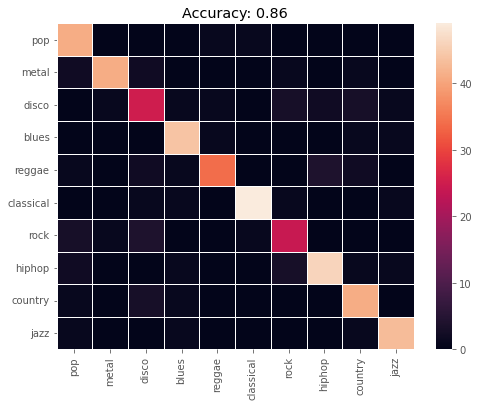

In [123]:
X_test = np.vstack([
    feature for feature_list in features_test 
    for feature in feature_list
])

y_test = np.array([label for label_list in labels_test for label in label_list])

y_pred = RFclf.predict(X_test)

plot_conf_matrix(y_pred, y_test, class_names)

### by record

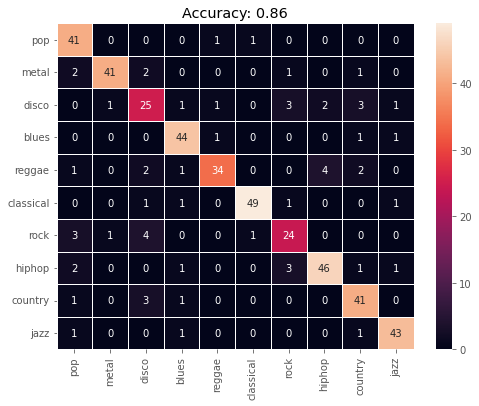

In [124]:
y_pred = np.array([
    RFclf.predict_proba(np.vstack(feature_list)).mean(0).argmax()
    for feature_list in features_test
])

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

# Test

In [125]:
test_features, _, test_pathes = load_folder_data(test_path, train=False, params=params)

  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_84086/2428182035.py:5: FutureWarning: Pass y=[-0.05193162 -0.08991308 -0.08466984 ...  0.35331666  0.3224939
  0.3422942 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spectrogram = librosa.feature.melspectrogram(signal, **params)
/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_84086/2428182035.py:5: FutureWarning: Pass y=[-0.06485112 -0.18959104 -0.15964712 ...  0.09922283  0.07147105
  0.12379588] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spectrogram = librosa.feature.melspectrogram(signal, **params)
/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_84086/2428182035.py:5: FutureWarning: Pass y=[ 0.03948304 -0.10069812 -0.19283244 ... -0.26100552 -0.13067676
 -0.05576585] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spectrogram = lib

In [126]:
predictions = [
    class_names[
        RFclf.predict_proba(
            np.vstack(test_feature)
        ).mean(0).argmax()
    ]
    for test_feature in test_features
]

In [127]:
(
    pd.DataFrame({
        'index': [test_wav_path.name for test_wav_path in test_path.iterdir()],
        'genre': predictions
    })
    .to_csv('submitForest.csv', index=False)
)